In [19]:
from utils.config import Config
import pandas as pd 
import numpy as np 
import mne
import seaborn as sns
from sklearn.pipeline import make_pipeline
sns.set(font_scale=1)
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.use('TkAgg')
%matplotlib notebook

from timeflux_rasr.estimation import RASR
from timeflux_blending.blending import Blending
print("Config LOADED")

Config LOADED


# Tutorial Notebook for rASR implementation 
It consists in:
- loading the eeg signal and events from the *xdf* and *set* files (
- visualizing the power spectral density (check dead channels and line noise) 
- apply a sliding window on both training and test data
- train rASR on the training data
- apply rASR on test data with blending
- compare outcomes with different rASR parameters

## Set paths and loading data

Reading /Users/louis/Dropbox/rASR Data/calibration data/sme_1_1.xdf_filt.fdt
Reading /Users/louis/Dropbox/rASR Data/filtered/sme_1_1.xdf_filt.fdt
Files LOADED


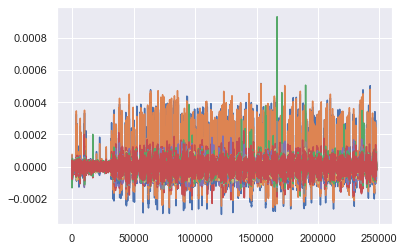

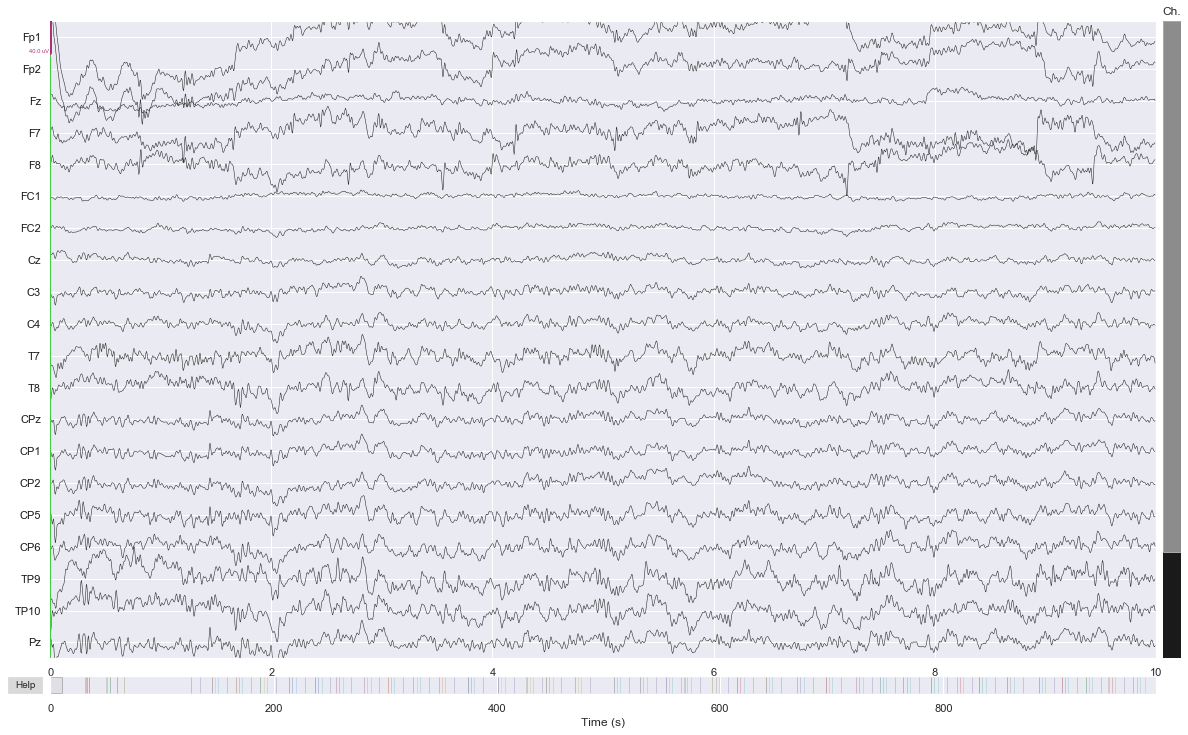

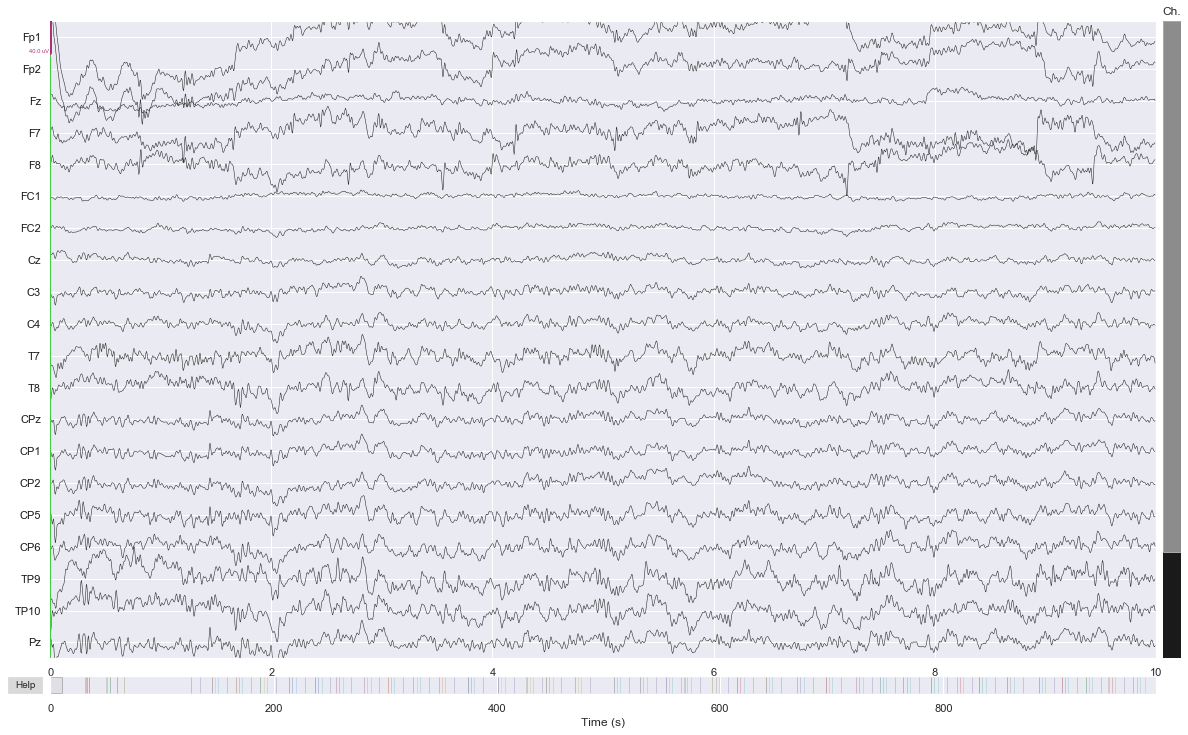

In [27]:
training_files   = '/Users/louis/Dropbox/rASR Data/calibration data/sme_1_1.xdf_filt.set'
test_files       = '/Users/louis/Dropbox/rASR Data/filtered/sme_1_1.xdf_filt.set'

mne_eeg_training = mne.io.read_raw_eeglab(training_files)
mne_eeg_test     = mne.io.read_raw_eeglab(test_files)
print("Files LOADED")
plt.close("all")
plt.plot(mne_eeg_test.get_data().T)

## Set RASR parameters, apply epoching and prepare pipelines

In [15]:
window_len        = 0.5  # in seconds
window_overlap    = 0.9  # in ratio of window_len
rejection_cutoff  = 5    # in std from the estimated distribution

# create fake events for the epoching
eventcode, interval, start, stop = 1, (1 - window_overlap) * window_len, 5, None
events_training   = mne.make_fixed_length_events(mne_eeg_training,    
                                                 id=eventcode, 
                                                 duration=interval,
                                                 start = start,
                                                 stop = stop)
events_test   = mne.make_fixed_length_events(mne_eeg_test, 
                                                 id=eventcode, 
                                                 duration=interval, 
                                                 start = start,
                                                 stop = stop)
X_training        = mne.Epochs(raw=mne_eeg_training, events=events_training).get_data()
X_test            = mne.Epochs(raw=mne_eeg_test, events=events_test).get_data()

rASR_pipeline     = make_pipeline(RASR(rejection_cutoff=rejection_cutoff))
blending_pipeline = make_pipeline(Blending(window_overlap=interval, merge=True))


1100 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1100 events and 176 original time points ...
10 bad epochs dropped
19700 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 19700 events and 176 original time points ...
10 bad epochs dropped


TypeError: window_overlap must int